# Facility Location for temporal markets using PuLP and UrbanPy

### General imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
sys.path.append('..')
import urbanpy as up
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as cx
import shapely
import numpy as np
import re
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pulp import *

### Data preparation

First, we need our set of possible facilities to activate. To construct it we will

* Download a polygon from a Lima district
* Get its bounds
* Download data from possible parks and pitches

In [3]:
sjl = up.download.nominatim_osm('San Juan de Lurigancho, Lima')

<AxesSubplot:>

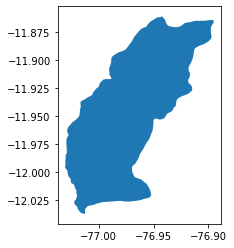

In [4]:
sjl.plot()

Now we are going to create a custom query for the overpass api to download parks an pitches within the district polygon. You can try your own cutom querys [here](https://overpass-turbo.eu/).

In [5]:
parks_pitchs_gdf, _ = up.download.overpass(type_of_data="way", query={'leisure': ['park', 'pitch']}, mask=sjl)

In [6]:
parks_pitchs_gdf.head()

,type,id,bounds,nodes,geometry,tags,poi_type
1622,way,877315795,"{'minlat': -12.0184928, 'minlon': -76.9554171,...","[8162655708, 8162655707, 8162655706, 816265570...","POLYGON ((-76.95524 -12.01814, -76.95522 -12.0...","{'leisure': 'pitch', 'sport': 'futsal', 'surfa...",pitch
1621,way,877315794,"{'minlat': -12.0184908, 'minlon': -76.9552267,...","[8162655704, 8162655703, 8162655702, 816265570...","POLYGON ((-76.95505 -12.01814, -76.95503 -12.0...","{'leisure': 'pitch', 'sport': 'futsal', 'surfa...",pitch
1721,way,933140557,"{'minlat': -12.0167803, 'minlon': -76.9561232,...","[8649752764, 8649752761, 8649752762, 864975276...","POLYGON ((-76.95602 -12.01651, -76.95585 -12.0...","{'leisure': 'pitch', 'sport': 'futsal', 'surfa...",pitch
867,way,522482717,"{'minlat': -11.9449407, 'minlon': -76.9421902,...","[5088706621, 5088706622, 5088706623, 508870662...","POLYGON ((-76.94196 -11.94462, -76.94202 -11.9...","{'leisure': 'pitch', 'sport': 'futsal'}",pitch
1344,way,829497149,"{'minlat': -11.9321548, 'minlon': -76.9467681,...","[7742236265, 7742236264, 7742236263, 774223626...","POLYGON ((-76.94637 -11.93177, -76.94656 -11.9...","{'leisure': 'pitch', 'sport': 'futsal', 'surfa...",pitch


The parks and pitches area in meters is needed to filter the possible candidates. Before calculating the polygon area, first we need to project to UTM

In [7]:
parks_pitchs_gdf_proj = parks_pitchs_gdf.to_crs(epsg=32718)
parks_pitchs_gdf['area'] = parks_pitchs_gdf_proj.geometry.area

We need to caculate distances from other geometries to the polygon data, using the centroid is a simple but fairly good approximation

In [8]:
parks_pitchs_gdf['lat'] = parks_pitchs_gdf.geometry.centroid.y
parks_pitchs_gdf['lon'] = parks_pitchs_gdf.geometry.centroid.x

Construct the candidate set from Overpass POIs

In [9]:
candidates = parks_pitchs_gdf[['id', 'lat', 'lon', 'area']]
candidates = gpd.GeoDataFrame(candidates, geometry=gpd.points_from_xy(candidates['lon'], candidates['lat']))
candidates.crs = 'EPSG:4326'

In [10]:
candidates['aforo'] = (candidates['area'] * 2).apply(np.floor).astype(int)

In [11]:
candidates.head()

,id,lat,lon,area,geometry,aforo
1622,877315795,-12.018316,-76.955316,750.395476,POINT (-76.95532 -12.01832),1500
1621,877315794,-12.018312,-76.955127,750.388154,POINT (-76.95513 -12.01831),1500
1721,933140557,-12.016643,-76.955989,408.089864,POINT (-76.95599 -12.01664),816
867,522482717,-11.944768,-76.942077,690.810238,POINT (-76.94208 -11.94477),1381
1344,829497149,-11.931913,-76.946571,1193.828254,POINT (-76.94657 -11.93191),2387


### Concatenating candidates with the national market census

In [12]:
markets = pd.read_csv('input/market_db.csv')
markets = gpd.GeoDataFrame(markets, geometry=gpd.points_from_xy(markets['longitude'], markets['latitude']))
markets.crs = 'EPSG:4326'

In [13]:
markets['aforo'] = markets.apply(
    lambda row: row['Area construida']*2 if row['Tipo de mercado']=='Minorista' else row['Area construida']*5,
    axis=1
)

In [14]:
merc = markets[markets.within(sjl.geometry[0])]

In [15]:
merc = merc[['longitude', 'latitude', 'aforo']].reset_index()

In [16]:
merc = gpd.GeoDataFrame(merc, geometry=gpd.points_from_xy(merc['longitude'], merc['latitude']))

In [17]:
merc = merc.rename(columns={'index': 'id', 'longitude': 'lon', 'latitude': 'lat'})

In [18]:
merc.shape

(123, 5)

In [19]:
markets = markets.loc[merc.id]

In [20]:
markets.isna().sum()

ID                                            0
Codigo_Departamento                           0
DEPARTAMENTO                                  0
Codigo_Provincia                              0
PROVINCIA                                     0
                                             ..
Egresos por otros gastos especifico (2015)    0
P64_40                                        0
Total de Egresos (2015)                       1
geometry                                      0
aforo                                         0
Length: 365, dtype: int64

In [21]:
candidates = candidates[['id', 'lat', 'lon', 'aforo', 'geometry']]

In [66]:
N_CANDIDATES = 10

In [22]:
# Select the N_CANDIDATES biggest candidates
candidates = candidates.sort_values('aforo').tail(N_CANDIDATES)

In [23]:
candidates = gpd.GeoDataFrame(pd.concat([candidates, merc])).reset_index(drop=True)

In [43]:
candidates.shape

(133, 5)

In [24]:
candidates.head()

,id,lat,lon,aforo,geometry
0,183453731,-12.024563,-76.981002,31096.0,POINT (-76.98100 -12.02456)
1,116948920,-11.970355,-77.007618,34201.0,POINT (-77.00762 -11.97035)
2,119442059,-11.973254,-76.993632,34601.0,POINT (-76.99363 -11.97325)
3,116933484,-11.974345,-77.005239,43102.0,POINT (-77.00524 -11.97434)
4,184184722,-12.006460,-77.013934,43608.0,POINT (-77.01393 -12.00646)


### Creating the demand an "clients" for the FLP

Now, we need to estimate the total population moving to these markets. To achieve this we need to

* Download HDX data
* Filter it to our district
* Convert it to hexagons

In [25]:
per_resources_df = up.download.search_hdx_dataset('peru')
per_resources_df

,created,name,population,size_mb,url
id,,,,,
0,2019-06-11,population_per_2018-10-01.csv.zip,Overall population density,19.36,https://data.humdata.org/dataset/4e74db39-87f1...
2,2019-06-11,PER_children_under_five_2019-06-01_csv.zip,Children (ages 0-5),16.60,https://data.humdata.org/dataset/4e74db39-87f1...
4,2019-06-11,PER_elderly_60_plus_2019-06-01_csv.zip,Elderly (ages 60+),16.59,https://data.humdata.org/dataset/4e74db39-87f1...
6,2019-06-11,PER_men_2019-06-01_csv.zip,Men,16.64,https://data.humdata.org/dataset/4e74db39-87f1...
8,2019-06-11,PER_women_2019-06-01_csv.zip,Women,16.63,https://data.humdata.org/dataset/4e74db39-87f1...
10,2019-06-11,PER_women_of_reproductive_age_15_49_2019-06-01...,Women of reproductive age (ages 15-49),16.62,https://data.humdata.org/dataset/4e74db39-87f1...
12,2019-06-11,PER_youth_15_24_2019-06-01_csv.zip,Youth (ages 15-24),16.61,https://data.humdata.org/dataset/4e74db39-87f1...


In [26]:
pop = up.download.get_hdx_dataset(per_resources_df, 0)

In [27]:
pop_sjl = up.geom.filter_population(pop, sjl)

In [28]:
hex_sjl = up.geom.gen_hexagons(8, sjl)

<AxesSubplot:>

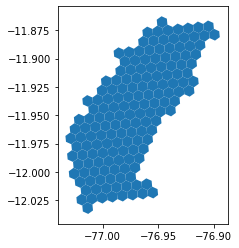

In [29]:
hex_sjl.plot()

Merging both layers

In [30]:
pop_sjl.isna().sum()

latitude           0
longitude          0
population_2015    0
population_2020    0
geometry           0
dtype: int64

In [31]:
hex_sjl.isna().sum()

hex         0
geometry    0
dtype: int64

In [32]:
hex_sjl = up.geom.merge_shape_hex(
    hex_sjl, 
    pop_sjl, 
    how='inner', 
    predicate='intersects', 
    agg={'population_2020': 'sum'}
)

In [33]:
hex_sjl.isna().sum()

hex                 0
geometry            0
population_2020    22
dtype: int64

In [34]:
hex_sjl.fillna(0, inplace=True)

<AxesSubplot:>

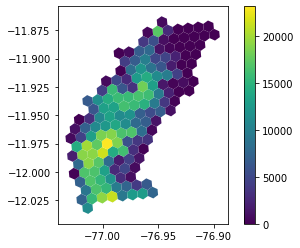

In [35]:
hex_sjl.plot(column='population_2020', legend=True)

## Distance matrix calculation

To estimate the cost for our FLP, we will use walking travel time. For this we need to

* Setup the OSRM server
* Get the distance matrix
* Shutdown the server

In [36]:
up.routing.start_osrm_server('peru', 'south-america', 'foot')

Starting server ...
osrm_routing_server_south-america_peru_foot
Server was started succesfully


To compute_osrm_dist_matrix we need Point geometry (We are going to use each hexagon centroid)

In [37]:
hex_sjl_centroids = hex_sjl.copy() # Copy original gdf
hex_sjl_centroids.geometry = hex_sjl_centroids.geometry.centroid # Replace Polygon for Centroid 

In [38]:
print(hex_sjl_centroids.shape[0], candidates.shape[0])

160 133


Now we are going to calculate the distance matrix. This operation is time expensive this may take several minutes ...

In [39]:
try:
    cost_mat = np.load('output/distance_matrix.npy')
except:
    distance, duration = up.routing.compute_osrm_dist_matrix(hex_sjl_centroids, candidates);
    cost_mat = duration.T
    np.save('output/distance_matrix.npy', cost_mat) # save the file to avoid running this function again    

Origins:   0%|          | 0/160 [00:00<?, ?it/s]

Destinations:   0%|          | 0/133 [00:00<?, ?it/s]

In [40]:
up.routing.stop_osrm_server('peru', 'south-america', 'foot')

Server was stoped succesfully


### Constructing PuLP sets and variables

Set an the number of facilities to be activated, plus the number of current markets

In [67]:
FACILITIES_P = 5

In [45]:
p = FACILITIES_P + merc.shape[0]

In [46]:
p

128

Build the facility and customer set as lists, as per PuLP requirements

In [47]:
candidates = candidates.reset_index(drop=True)

In [48]:
candidates.shape

(133, 5)

In [49]:
customers = list(hex_sjl_centroids.index)
facilities = [f'FAC_{i}' for i in candidates.index]

Now we create dictionaries for the demand and cost, associating each customer (hexagon) to the demand (population) and each facility (park/pitch) the respective cost (travel time) to each customer 

In [50]:
demand = {i: hex_sjl.loc[i, 'population_2020'] for i in hex_sjl.index}

In [51]:
cost_dict = {facilities[i]: {customers[j]: cost_mat[i][j] for j in hex_sjl.index} for i in candidates.index}

In [57]:
capacity = {facilities[i]: markets.loc[merc_id, 'aforo'] for i, merc_id in enumerate(merc.id)}

Create problem variable for PuLP

In [58]:
prob = LpProblem('FLP_Markets_SJL', LpMinimize)

We create the decision variable $x_{ij}$, representing the percentage of service assigned from a facility to a customer, setting 0 as the lower bound

In [59]:
x = LpVariable.dicts('Service', 
                    [(i,j) for j in customers for i in facilities],
                    0)

Now we create the decision variable to activate a facility $y_i$

In [60]:
y = LpVariable.dicts('Activation',
                     facilities,
                     0,1, LpBinary)

Setting the objective function $$ \sum_{i=1}^{n} \sum_{j=1}^{m} d_{j} c_{ij} x_{ij} $$

In [61]:
prob += lpSum(lpSum(demand[j]*cost_dict[i][j]*x[i,j] for i in facilities) for j in customers)

We add the first constraint $$ \sum_{i=1}^{n} x_{ij} = 1 \quad \forall j \in \text{Customers}$$

In [62]:
for j in customers:
    prob += lpSum(x[i,j] for i in facilities) == 1

Adding the second constraint $$ \sum_{i=1}^{n} y_{i} = p $$

In [63]:
prob += lpSum(y[i] for i in facilities) == p

Third constraint $$ x_{i,j} ≤ y_{i} \quad \forall i \in \text{Facilities} \quad \forall j \in \text{Customers}$$

In [64]:
for i in facilities:
    for j in customers:
        prob += x[i,j] <= y[i]

We need to keep the markets active, focusing on activating only additional facilities (avoid selecting already active markets)

In [70]:
for i in facilities[N_CANDIDATES:]:
    prob += y[i] == 1

Finally, as to maintain proper social distancing, we set a capacity constraint $$ \sum_{j=1}^{m} x_{ij} ≤ c_{i} \quad \forall i \in \text{Facilities}$$

In [71]:
for i in capacity:
    prob += lpSum(x[i,j] for j in customers) <= capacity[i]

Solve (a custom solver may be added in the solve method)

In [ ]:
prob.solve();

Check solution status

In [74]:
print("Status:", LpStatus[prob.status])

Status: Optimal


Obtain the demand assignments

In [75]:
x_vars = [[0 for j in range(len(customers))] for i in range(len(facilities))]

for v in prob.variables():
    if 'Activation' not in v.name:
        i, j = re.findall('\d+', v.name)
        x_vars[int(i)][int(j)] = v.varValue

In [76]:
y_vars = np.zeros_like(facilities)

for v in prob.variables():
    if 'Activation' in v.name:
        ix = int(re.findall('\d+', v.name)[0])
        y_vars[ix] = v.varValue

y_vars = y_vars.astype(float)

In [77]:
x_vars, y_vars = np.array(x_vars), np.array(y_vars)

Add some flags useful for visualization purposes

In [78]:
candidates['is_active'] = y_vars

In [79]:
candidates['is_market'] = 0

In [80]:
candidates.loc[N_CANDIDATES:, 'is_market'] = 1

Verify that the number of parks and pitches candidates selected is equal to FACILITIES_P

In [85]:
FACILITIES_P == candidates[(candidates['is_active'] == 1) & (candidates['is_market'] == 0)].shape[0]

True

In [86]:
candidates.reset_index(drop=True, inplace=True)

Save results

In [87]:
# Raw
np.save('output/assignments.npy', x_vars)
np.save('output/facilities.npy', y_vars)

In [88]:
# For viz
candidates.to_file('output/facilities', index=False)

In [104]:
park_and_pitches_filter = parks_pitchs_gdf['id'].isin(candidates[candidates['is_market'] == 0]['id'])
park_and_pitches_candidates = parks_pitchs_gdf[park_and_pitches_filter]

In [ ]:
park_and_pitches_candidates = park_and_pitches_candidates.merge(
    candidates[['id', 'aforo', 'is_active']], on='id')

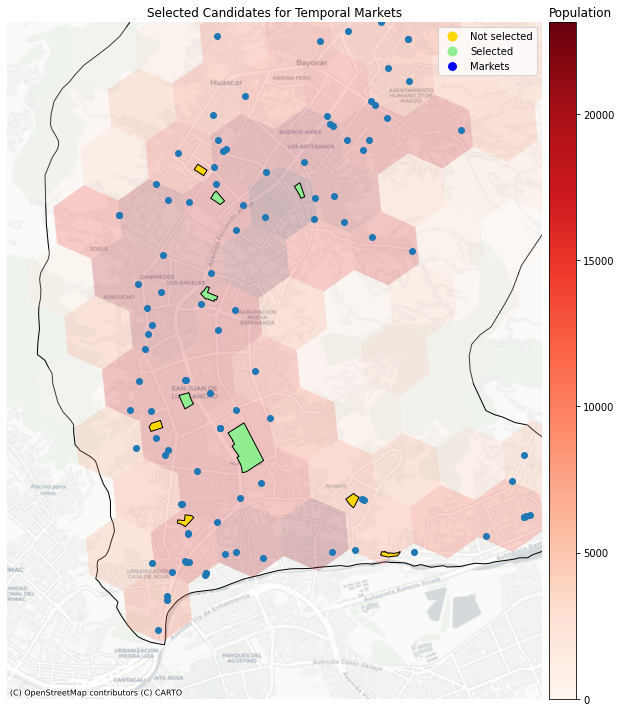

In [192]:
fig, ax = plt.subplots(1, 1, figsize=(40,10))

plt.title('Selected Candidates for Temporal Markets')

# Colorbar for population choropleth map
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cax.set_title('Population', loc='left')

# Administrative boundaries
sjl.plot(facecolor='none', ax=ax) 
# Population
hex_sjl.plot('population_2020', cmap='Reds', alpha=0.25, legend=True, ax=ax, cax=cax)
# Current Markets
merc.plot(ax=ax, legend=True)
# Candidates
park_and_pitches_candidates.plot('is_active', cmap=cmap,  edgecolor='k', 
                                 legend=True, categorical=True, ax=ax)


# Format map legend
legend = ax.get_legend()
lines = legend.get_lines()
legend.remove()
markets_legend = Line2D([0], [0], marker='o', color='w', 
                        markerfacecolor='b', markersize=10)
lines.append(markets_legend)
texts = ['Not selected', 'Selected', 'Markets']
ax.legend(lines, texts)

# Set map limits
minx, miny, maxx, maxy = park_and_pitches_candidates.total_bounds
margins = 0.02
ax.set_xlim(minx-margins, maxx+margins)
ax.set_ylim(miny-margins, maxy+margins)

# Add a basemap
ax.set_axis_off()
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs='EPSG:4326')

plt.tight_layout()